In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img, norm):
    """
    :param img: (PyTorch Tensor)
    """
    if norm:
        # unnormalize
        img = img / 2 + 0.5    
        
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def get_image(img):
    """
    convert a tensor to images suitable for plotting
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    return np.transpose(npimg, (1, 2, 0))

def plot_loss_acc(train_loss, val_loss, train_acc, val_acc):
    x = np.arange(1, len(train_loss) + 1)

    fig,axs = plt.subplots(1, 2, figsize=(16,6))
    axs[0].plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    axs[0].plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    axs[0].set_title("Evolution of the training, validation and test loss")

    axs[1].plot(x, train_acc, color=colors[0], label="Training accuracy", linewidth=2)
    axs[1].plot(x, val_acc, color=colors[1], label="Validation accuracy", linewidth=2)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')
    axs[1].set_title("Evolution of the training, validation and test accuracy")
    plt.show()
    

def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()

def plot_pvals(pvals, labels):
    idx_in = np.where(labels==0)[0]
    idx_out = np.where(labels==1)[0]

    pvals_in = np.array(pvals)[idx_in]
    pvals_out = np.array(pvals)[idx_out]

    plt.figure(figsize=(8,6))
    plt.hist(pvals_in, bins=100, alpha=0.5, label="inliers")
    plt.hist(pvals_out, bins=100, alpha=0.5, label="outliers")
    plt.legend()
    plt.show

    print('Average p-value for inliers is {:3f}, average p-value for outliers is {:3f}.'\
          .format(np.mean(pvals_in), np.mean(pvals_out)))
    

def evaluate_bh(pvals, labels, alpha):
    idx_in = np.where(labels==0)[0]
    idx_out = np.where(labels==1)[0]
    
    # Apply BH
    purity_test = len(idx_in)/len(pvals)
    reject, _, _, _ = multipletests(pvals, alpha=alpha/(1-purity_test), method='fdr_bh')

    # Evaluate FDP and Power
    rejections = np.sum(reject)
    if rejections > 0:
        fdp = np.sum(reject[idx_in])/reject.shape[0] 
        power = np.sum(reject[idx_out])/len(idx_out)
    else:
        fdp = 0
        power = 0
    return fdp, power

def evaluate_predictions(S, y):
    coverage = np.mean([y[i] in S[i] for i in range(len(y))])
    length = np.mean([len(S[i]) for i in range(len(y))])
    idx_cover = np.where([y[i] in S[i] for i in range(len(y))])[0]
    length_cover = np.mean([len(S[i]) for i in idx_cover])
    return coverage, length, length_cover

def evaluate_marginal(S, y):
    coverage, length, length_cover = evaluate_predictions(S, y)
    print('Marginal coverage:       {:2.3%}'.format(coverage))
    print('Average size:            {:2.3f}'.format(length))
    print('Average size | coverage: {:2.3f}'.format(length_cover))

def evaluate_conditional(S, y):
    n_class = len(np.unique(y))
    for i in range(n_class):
        label = i
        idx = np.where(y==label)[0]
        coverage, length, length_cover = evaluate_predictions(np.array(S, dtype=object)[idx], np.array(y)[idx])
        print('Conditional coverage for label {}:       {:2.3%}'.format(classes[label], coverage))
        print('Average size:            {:2.3f}'.format(length))
        print('Average size | coverage: {:2.3f}'.format(length_cover))

In [2]:
import torch as th
from tqdm import tqdm
import torchvision
import sys, os
from torchvision import transforms
from torchvision import datasets

sys.path.append('../ConformalizedES')
sys.path.append('../third_party')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Experiment 1: CES for anomaly detection

### Load MNIST dataset

In [3]:
# Download the MNIST Dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=0.5, std=0.5)])

train_set_full = datasets.MNIST(root = "./data", train = True, download = True, transform=transform)
test_set_full = datasets.MNIST(root = "./data", train = False, download = True, transform=transform)

In [4]:
from datasetMaker import get_class_i, DatasetMaker

x_train_full = train_set_full.data
y_train_full = train_set_full.targets
x_test_full = test_set_full.data
y_test_full = test_set_full.targets

# Train set composed only of number 0
train_set = \
    DatasetMaker(
        [get_class_i(x_train_full, y_train_full, 0)]
    )

# Test set is a mixture of number 0 and 8
test_set = \
    DatasetMaker(
        [get_class_i(x_test_full, y_test_full, 0),
        get_class_i(x_test_full, y_test_full, 8),
]
    )

print('total number of available training data is: {:d}.'.format(len(train_set)))
print('total number of test data is {:d} in which {:d} are label 0 test data, {:d} are label 8 test data.'\
      .format(len(test_set), test_set.lengths[0],test_set.lengths[1]))

total number of available training data is: 5923.
total number of test data is 1954 in which 980 are label 0 test data, 974 are label 8 test data.


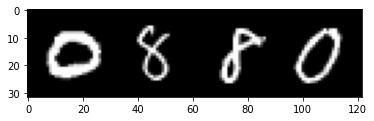

In [5]:
# Plot some sample test data
example_loader = th.utils.data.DataLoader(test_set, shuffle=True, batch_size=4, num_workers=0)
dataiter = iter(example_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images), norm=False)

### Benchmark data-splitting vs CES data-splitting

In [46]:
from torch.utils.data.sampler import SubsetRandomSampler
num_workers = 0

seed = 1
np.random.seed(seed)
th.manual_seed(seed)

# MNIST is a simple dataset, hence we only take 300 inlier data to demonstrate
# Benchmark data splitting: equally split the data into 3 sets
n_full = len(train_set)
n_data = 300
n_es_bm = int(n_data*0.25)
n_calib_bm = n_es_bm
n_train_bm = n_data-n_calib_bm-n_es_bm


train_set_bm, es_set_bm, calib_set_bm, _ = th.utils.data.random_split(train_set,\
                                 [n_train_bm, n_es_bm, n_calib_bm, n_full-n_data])

print("Use {:d} training samples, {:d} early stopping samples, {:d} calibration samples for the Data splitting method."\
     .format(n_train_bm, n_es_bm, n_calib_bm))
# CES data splitting: calibration set is not needed, merge back to the training set
n_train_ces = n_data-n_es_bm
n_escal_ces = n_es_bm

train_set_ces, escal_set_ces, _ = th.utils.data.random_split(train_set,\
                                 [n_train_ces, n_escal_ces, n_full-n_data])
print("Use {:d} training samples, {:d} early stopping samples, {:d} calibration samples for the CES method."\
     .format(n_train_ces, n_escal_ces, n_escal_ces))


Use 150 training samples, 75 early stopping samples, 75 calibration samples for the Data splitting method.
Use 225 training samples, 75 early stopping samples, 75 calibration samples for the CES method.


In [30]:
# Create data loader objects
# For benchmarks
batch_size = 10
num_workers = 0

train_loader_bm = th.utils.data.DataLoader(train_set_bm, batch_size=batch_size,
                                          num_workers=num_workers)

es_loader_bm = th.utils.data.DataLoader(es_set_bm, batch_size=batch_size,
                                          num_workers=num_workers)

calib_loader_bm = th.utils.data.DataLoader(calib_set_bm, batch_size=batch_size,
                                          num_workers=num_workers)

# For CES
train_loader_ces = th.utils.data.DataLoader(train_set_ces, batch_size=batch_size,
                                          num_workers=num_workers)

escal_loader_ces = th.utils.data.DataLoader(escal_set_ces, batch_size=batch_size,
                                          num_workers=num_workers)

In [31]:
# Test loader

seed = 1
np.random.seed(seed)
th.manual_seed(seed)

n_test_samples = 100
n_test = len(test_set)

test_sample, more_sample = th.utils.data.random_split(test_set,[n_test_samples, n_test-n_test_samples])
test_loader = th.utils.data.DataLoader(test_sample, batch_size=n_test_samples, num_workers=num_workers)

# get all test images
dataiter = iter(test_loader)
inputs, labels = dataiter.next()

### Define Autoencoder

In [32]:
from method import CES_oneClass
from networks import ConvAutoencoder
import torch.optim as optim

# Define the model parameters

lr = 0.1
n_epoch = 200

# Create loss and optimizer
# CES_oneClass object will assume criterion takes three parameters: output, input and target, 
# create wrapper function to modify the criterion.
net_bm = ConvAutoencoder()
Loss = th.nn.MSELoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, inputs)
optimizer_bm = optim.Adam(net_bm.parameters(), lr=lr)

In [33]:
seed = 1
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

### Train benchmark models and compute conformal p-values

In [34]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# Initialize the CES class with model parameters
CES_oc_bm = CES_oneClass(net_bm, device, train_loader_bm, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=es_loader_bm, criterion=criterion,optimizer=optimizer_bm)

===== HYPERPARAMETERS =====
batch_size= 10
n_epochs= 200
learning_rate= 0.1


In [35]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_oc_bm.full_train(save_dir = './models/oneClass/benchmarks', save_every = save_every)

Epoch 1 of 200, 6% 	 train_loss: 0.31  took: 0.01s
Epoch 1 of 200, 13% 	 train_loss: 0.27  took: 0.01s
Epoch 1 of 200, 20% 	 train_loss: 0.17  took: 0.02s
Epoch 1 of 200, 26% 	 train_loss: 0.16  took: 0.01s
Epoch 1 of 200, 33% 	 train_loss: 0.16  took: 0.02s
Epoch 1 of 200, 40% 	 train_loss: 0.15  took: 0.01s
Epoch 1 of 200, 46% 	 train_loss: 0.15  took: 0.00s
Epoch 1 of 200, 53% 	 train_loss: 0.15  took: 0.02s
Epoch 1 of 200, 60% 	 train_loss: 0.15  took: 0.02s
Epoch 1 of 200, 66% 	 train_loss: 0.14  took: 0.02s
Epoch 1 of 200, 73% 	 train_loss: 0.13  took: 0.02s
Epoch 1 of 200, 80% 	 train_loss: 0.19  took: 0.02s
Epoch 1 of 200, 86% 	 train_loss: 0.17  took: 0.02s
Epoch 1 of 200, 93% 	 train_loss: 0.13  took: 0.02s
Epoch 1 of 200, 100% 	 train_loss: 0.15  took: 0.03s
val_loss = 0.15
Snapshot saved at epoch 1.
Epoch 2 of 200, 6% 	 train_loss: 0.16  took: 0.01s
Epoch 2 of 200, 13% 	 train_loss: 0.16  took: 0.02s
Epoch 2 of 200, 20% 	 train_loss: 0.14  took: 0.02s
Epoch 2 of 200, 26% 	 

Epoch 11 of 200, 33% 	 train_loss: 0.16  took: 0.02s
Epoch 11 of 200, 40% 	 train_loss: 0.15  took: 0.01s
Epoch 11 of 200, 46% 	 train_loss: 0.15  took: 0.02s
Epoch 11 of 200, 53% 	 train_loss: 0.15  took: 0.02s
Epoch 11 of 200, 60% 	 train_loss: 0.15  took: 0.02s
Epoch 11 of 200, 66% 	 train_loss: 0.14  took: 0.02s
Epoch 11 of 200, 73% 	 train_loss: 0.13  took: 0.02s
Epoch 11 of 200, 80% 	 train_loss: 0.19  took: 0.02s
Epoch 11 of 200, 86% 	 train_loss: 0.17  took: 0.02s
Epoch 11 of 200, 93% 	 train_loss: 0.13  took: 0.02s
Epoch 11 of 200, 100% 	 train_loss: 0.15  took: 0.01s
val_loss = 0.15
Snapshot saved at epoch 11.
Epoch 12 of 200, 6% 	 train_loss: 0.16  took: 0.04s
Epoch 12 of 200, 13% 	 train_loss: 0.16  took: 0.03s
Epoch 12 of 200, 20% 	 train_loss: 0.14  took: 0.02s
Epoch 12 of 200, 26% 	 train_loss: 0.16  took: 0.03s
Epoch 12 of 200, 33% 	 train_loss: 0.16  took: 0.02s
Epoch 12 of 200, 40% 	 train_loss: 0.15  took: 0.02s
Epoch 12 of 200, 46% 	 train_loss: 0.15  took: 0.02s
Ep

Epoch 21 of 200, 60% 	 train_loss: 0.15  took: 0.02s
Epoch 21 of 200, 66% 	 train_loss: 0.14  took: 0.03s
Epoch 21 of 200, 73% 	 train_loss: 0.13  took: 0.02s
Epoch 21 of 200, 80% 	 train_loss: 0.19  took: 0.02s
Epoch 21 of 200, 86% 	 train_loss: 0.17  took: 0.02s
Epoch 21 of 200, 93% 	 train_loss: 0.13  took: 0.02s
Epoch 21 of 200, 100% 	 train_loss: 0.15  took: 0.02s
val_loss = 0.15
Snapshot saved at epoch 21.
Epoch 22 of 200, 6% 	 train_loss: 0.16  took: 0.02s
Epoch 22 of 200, 13% 	 train_loss: 0.16  took: 0.01s
Epoch 22 of 200, 20% 	 train_loss: 0.14  took: 0.02s
Epoch 22 of 200, 26% 	 train_loss: 0.16  took: 0.04s
Epoch 22 of 200, 33% 	 train_loss: 0.16  took: 0.01s
Epoch 22 of 200, 40% 	 train_loss: 0.15  took: 0.02s
Epoch 22 of 200, 46% 	 train_loss: 0.15  took: 0.02s
Epoch 22 of 200, 53% 	 train_loss: 0.15  took: 0.02s
Epoch 22 of 200, 60% 	 train_loss: 0.15  took: 0.02s
Epoch 22 of 200, 66% 	 train_loss: 0.14  took: 0.03s
Epoch 22 of 200, 73% 	 train_loss: 0.13  took: 0.02s
Ep

Epoch 31 of 200, 60% 	 train_loss: 0.15  took: 0.06s
Epoch 31 of 200, 66% 	 train_loss: 0.14  took: 0.03s
Epoch 31 of 200, 73% 	 train_loss: 0.13  took: 0.03s
Epoch 31 of 200, 80% 	 train_loss: 0.19  took: 0.03s
Epoch 31 of 200, 86% 	 train_loss: 0.17  took: 0.02s
Epoch 31 of 200, 93% 	 train_loss: 0.13  took: 0.03s
Epoch 31 of 200, 100% 	 train_loss: 0.15  took: 0.03s
val_loss = 0.15
Snapshot saved at epoch 31.
Epoch 32 of 200, 6% 	 train_loss: 0.16  took: 0.02s
Epoch 32 of 200, 13% 	 train_loss: 0.16  took: 0.03s
Epoch 32 of 200, 20% 	 train_loss: 0.14  took: 0.03s
Epoch 32 of 200, 26% 	 train_loss: 0.16  took: 0.05s
Epoch 32 of 200, 33% 	 train_loss: 0.16  took: 0.03s
Epoch 32 of 200, 40% 	 train_loss: 0.15  took: 0.02s
Epoch 32 of 200, 46% 	 train_loss: 0.15  took: 0.04s
Epoch 32 of 200, 53% 	 train_loss: 0.15  took: 0.02s
Epoch 32 of 200, 60% 	 train_loss: 0.15  took: 0.03s
Epoch 32 of 200, 66% 	 train_loss: 0.14  took: 0.05s
Epoch 32 of 200, 73% 	 train_loss: 0.13  took: 0.02s
Ep

Epoch 41 of 200, 60% 	 train_loss: 0.15  took: 0.05s
Epoch 41 of 200, 66% 	 train_loss: 0.14  took: 0.03s
Epoch 41 of 200, 73% 	 train_loss: 0.13  took: 0.02s
Epoch 41 of 200, 80% 	 train_loss: 0.19  took: 0.02s
Epoch 41 of 200, 86% 	 train_loss: 0.17  took: 0.05s
Epoch 41 of 200, 93% 	 train_loss: 0.13  took: 0.03s
Epoch 41 of 200, 100% 	 train_loss: 0.15  took: 0.03s
val_loss = 0.15
Snapshot saved at epoch 41.
Epoch 42 of 200, 6% 	 train_loss: 0.16  took: 0.03s
Epoch 42 of 200, 13% 	 train_loss: 0.16  took: 0.03s
Epoch 42 of 200, 20% 	 train_loss: 0.14  took: 0.03s
Epoch 42 of 200, 26% 	 train_loss: 0.16  took: 0.04s
Epoch 42 of 200, 33% 	 train_loss: 0.16  took: 0.02s
Epoch 42 of 200, 40% 	 train_loss: 0.15  took: 0.03s
Epoch 42 of 200, 46% 	 train_loss: 0.15  took: 0.06s
Epoch 42 of 200, 53% 	 train_loss: 0.15  took: 0.06s
Epoch 42 of 200, 60% 	 train_loss: 0.15  took: 0.06s
Epoch 42 of 200, 66% 	 train_loss: 0.14  took: 0.05s
Epoch 42 of 200, 73% 	 train_loss: 0.13  took: 0.04s
Ep

Epoch 51 of 200, 73% 	 train_loss: 0.13  took: 0.06s
Epoch 51 of 200, 80% 	 train_loss: 0.19  took: 0.03s
Epoch 51 of 200, 86% 	 train_loss: 0.17  took: 0.03s
Epoch 51 of 200, 93% 	 train_loss: 0.13  took: 0.03s
Epoch 51 of 200, 100% 	 train_loss: 0.15  took: 0.03s
val_loss = 0.15
Snapshot saved at epoch 51.
Epoch 52 of 200, 6% 	 train_loss: 0.16  took: 0.03s
Epoch 52 of 200, 13% 	 train_loss: 0.16  took: 0.03s
Epoch 52 of 200, 20% 	 train_loss: 0.14  took: 0.03s
Epoch 52 of 200, 26% 	 train_loss: 0.16  took: 0.01s
Epoch 52 of 200, 33% 	 train_loss: 0.16  took: 0.03s
Epoch 52 of 200, 40% 	 train_loss: 0.15  took: 0.02s
Epoch 52 of 200, 46% 	 train_loss: 0.15  took: 0.03s
Epoch 52 of 200, 53% 	 train_loss: 0.15  took: 0.03s
Epoch 52 of 200, 60% 	 train_loss: 0.15  took: 0.03s
Epoch 52 of 200, 66% 	 train_loss: 0.14  took: 0.03s
Epoch 52 of 200, 73% 	 train_loss: 0.13  took: 0.02s
Epoch 52 of 200, 80% 	 train_loss: 0.19  took: 0.03s
Epoch 52 of 200, 86% 	 train_loss: 0.17  took: 0.03s
Ep

Epoch 61 of 200, 53% 	 train_loss: 0.15  took: 0.03s
Epoch 61 of 200, 60% 	 train_loss: 0.15  took: 0.02s
Epoch 61 of 200, 66% 	 train_loss: 0.14  took: 0.03s
Epoch 61 of 200, 73% 	 train_loss: 0.13  took: 0.03s
Epoch 61 of 200, 80% 	 train_loss: 0.19  took: 0.02s
Epoch 61 of 200, 86% 	 train_loss: 0.17  took: 0.03s
Epoch 61 of 200, 93% 	 train_loss: 0.13  took: 0.06s
Epoch 61 of 200, 100% 	 train_loss: 0.15  took: 0.03s
val_loss = 0.15
Snapshot saved at epoch 61.
Epoch 62 of 200, 6% 	 train_loss: 0.16  took: 0.06s
Epoch 62 of 200, 13% 	 train_loss: 0.16  took: 0.02s
Epoch 62 of 200, 20% 	 train_loss: 0.14  took: 0.03s
Epoch 62 of 200, 26% 	 train_loss: 0.16  took: 0.02s
Epoch 62 of 200, 33% 	 train_loss: 0.16  took: 0.02s
Epoch 62 of 200, 40% 	 train_loss: 0.15  took: 0.03s
Epoch 62 of 200, 46% 	 train_loss: 0.15  took: 0.02s
Epoch 62 of 200, 53% 	 train_loss: 0.15  took: 0.03s
Epoch 62 of 200, 60% 	 train_loss: 0.15  took: 0.02s
Epoch 62 of 200, 66% 	 train_loss: 0.14  took: 0.02s
Ep

Epoch 71 of 200, 66% 	 train_loss: 0.14  took: 0.05s
Epoch 71 of 200, 73% 	 train_loss: 0.13  took: 0.03s
Epoch 71 of 200, 80% 	 train_loss: 0.19  took: 0.03s
Epoch 71 of 200, 86% 	 train_loss: 0.17  took: 0.03s
Epoch 71 of 200, 93% 	 train_loss: 0.13  took: 0.02s
Epoch 71 of 200, 100% 	 train_loss: 0.15  took: 0.05s
val_loss = 0.15
Snapshot saved at epoch 71.
Epoch 72 of 200, 6% 	 train_loss: 0.16  took: 0.02s
Epoch 72 of 200, 13% 	 train_loss: 0.16  took: 0.02s
Epoch 72 of 200, 20% 	 train_loss: 0.14  took: 0.03s
Epoch 72 of 200, 26% 	 train_loss: 0.16  took: 0.03s
Epoch 72 of 200, 33% 	 train_loss: 0.16  took: 0.03s
Epoch 72 of 200, 40% 	 train_loss: 0.15  took: 0.04s
Epoch 72 of 200, 46% 	 train_loss: 0.15  took: 0.03s
Epoch 72 of 200, 53% 	 train_loss: 0.15  took: 0.03s
Epoch 72 of 200, 60% 	 train_loss: 0.15  took: 0.02s
Epoch 72 of 200, 66% 	 train_loss: 0.14  took: 0.02s
Epoch 72 of 200, 73% 	 train_loss: 0.13  took: 0.05s
Epoch 72 of 200, 80% 	 train_loss: 0.19  took: 0.03s
Ep

Epoch 81 of 200, 60% 	 train_loss: 0.07  took: 0.02s
Epoch 81 of 200, 66% 	 train_loss: 0.07  took: 0.03s
Epoch 81 of 200, 73% 	 train_loss: 0.07  took: 0.04s
Epoch 81 of 200, 80% 	 train_loss: 0.08  took: 0.03s
Epoch 81 of 200, 86% 	 train_loss: 0.07  took: 0.03s
Epoch 81 of 200, 93% 	 train_loss: 0.07  took: 0.02s
Epoch 81 of 200, 100% 	 train_loss: 0.07  took: 0.02s
val_loss = 0.07
Snapshot saved at epoch 81.
Epoch 82 of 200, 6% 	 train_loss: 0.07  took: 0.03s
Epoch 82 of 200, 13% 	 train_loss: 0.08  took: 0.03s
Epoch 82 of 200, 20% 	 train_loss: 0.06  took: 0.03s
Epoch 82 of 200, 26% 	 train_loss: 0.08  took: 0.02s
Epoch 82 of 200, 33% 	 train_loss: 0.07  took: 0.03s
Epoch 82 of 200, 40% 	 train_loss: 0.07  took: 0.03s
Epoch 82 of 200, 46% 	 train_loss: 0.07  took: 0.02s
Epoch 82 of 200, 53% 	 train_loss: 0.07  took: 0.03s
Epoch 82 of 200, 60% 	 train_loss: 0.07  took: 0.02s
Epoch 82 of 200, 66% 	 train_loss: 0.07  took: 0.02s
Epoch 82 of 200, 73% 	 train_loss: 0.07  took: 0.02s
Ep

Epoch 91 of 200, 53% 	 train_loss: 0.07  took: 0.03s
Epoch 91 of 200, 60% 	 train_loss: 0.07  took: 0.03s
Epoch 91 of 200, 66% 	 train_loss: 0.07  took: 0.03s
Epoch 91 of 200, 73% 	 train_loss: 0.07  took: 0.02s
Epoch 91 of 200, 80% 	 train_loss: 0.08  took: 0.05s
Epoch 91 of 200, 86% 	 train_loss: 0.07  took: 0.04s
Epoch 91 of 200, 93% 	 train_loss: 0.07  took: 0.03s
Epoch 91 of 200, 100% 	 train_loss: 0.08  took: 0.03s
val_loss = 0.07
Snapshot saved at epoch 91.
Epoch 92 of 200, 6% 	 train_loss: 0.07  took: 0.05s
Epoch 92 of 200, 13% 	 train_loss: 0.08  took: 0.02s
Epoch 92 of 200, 20% 	 train_loss: 0.06  took: 0.03s
Epoch 92 of 200, 26% 	 train_loss: 0.08  took: 0.02s
Epoch 92 of 200, 33% 	 train_loss: 0.07  took: 0.02s
Epoch 92 of 200, 40% 	 train_loss: 0.07  took: 0.01s
Epoch 92 of 200, 46% 	 train_loss: 0.07  took: 0.04s
Epoch 92 of 200, 53% 	 train_loss: 0.07  took: 0.05s
Epoch 92 of 200, 60% 	 train_loss: 0.07  took: 0.02s
Epoch 92 of 200, 66% 	 train_loss: 0.07  took: 0.02s
Ep

Epoch 101 of 200, 66% 	 train_loss: 0.07  took: 0.03s
Epoch 101 of 200, 73% 	 train_loss: 0.06  took: 0.02s
Epoch 101 of 200, 80% 	 train_loss: 0.08  took: 0.02s
Epoch 101 of 200, 86% 	 train_loss: 0.07  took: 0.01s
Epoch 101 of 200, 93% 	 train_loss: 0.07  took: 0.02s
Epoch 101 of 200, 100% 	 train_loss: 0.07  took: 0.02s
val_loss = 0.07
Snapshot saved at epoch 101.
Epoch 102 of 200, 6% 	 train_loss: 0.07  took: 0.04s
Epoch 102 of 200, 13% 	 train_loss: 0.07  took: 0.04s
Epoch 102 of 200, 20% 	 train_loss: 0.06  took: 0.02s
Epoch 102 of 200, 26% 	 train_loss: 0.08  took: 0.02s
Epoch 102 of 200, 33% 	 train_loss: 0.07  took: 0.02s
Epoch 102 of 200, 40% 	 train_loss: 0.07  took: 0.02s
Epoch 102 of 200, 46% 	 train_loss: 0.07  took: 0.02s
Epoch 102 of 200, 53% 	 train_loss: 0.07  took: 0.03s
Epoch 102 of 200, 60% 	 train_loss: 0.07  took: 0.02s
Epoch 102 of 200, 66% 	 train_loss: 0.07  took: 0.05s
Epoch 102 of 200, 73% 	 train_loss: 0.06  took: 0.03s
Epoch 102 of 200, 80% 	 train_loss: 0

Epoch 111 of 200, 66% 	 train_loss: 0.07  took: 0.01s
Epoch 111 of 200, 73% 	 train_loss: 0.07  took: 0.02s
Epoch 111 of 200, 80% 	 train_loss: 0.08  took: 0.02s
Epoch 111 of 200, 86% 	 train_loss: 0.07  took: 0.03s
Epoch 111 of 200, 93% 	 train_loss: 0.07  took: 0.02s
Epoch 111 of 200, 100% 	 train_loss: 0.07  took: 0.01s
val_loss = 0.07
Snapshot saved at epoch 111.
Epoch 112 of 200, 6% 	 train_loss: 0.07  took: 0.03s
Epoch 112 of 200, 13% 	 train_loss: 0.07  took: 0.03s
Epoch 112 of 200, 20% 	 train_loss: 0.06  took: 0.02s
Epoch 112 of 200, 26% 	 train_loss: 0.08  took: 0.02s
Epoch 112 of 200, 33% 	 train_loss: 0.07  took: 0.02s
Epoch 112 of 200, 40% 	 train_loss: 0.07  took: 0.03s
Epoch 112 of 200, 46% 	 train_loss: 0.07  took: 0.03s
Epoch 112 of 200, 53% 	 train_loss: 0.07  took: 0.02s
Epoch 112 of 200, 60% 	 train_loss: 0.07  took: 0.00s
Epoch 112 of 200, 66% 	 train_loss: 0.07  took: 0.03s
Epoch 112 of 200, 73% 	 train_loss: 0.07  took: 0.01s
Epoch 112 of 200, 80% 	 train_loss: 0

Epoch 121 of 200, 26% 	 train_loss: 0.08  took: 0.03s
Epoch 121 of 200, 33% 	 train_loss: 0.07  took: 0.02s
Epoch 121 of 200, 40% 	 train_loss: 0.07  took: 0.02s
Epoch 121 of 200, 46% 	 train_loss: 0.07  took: 0.01s
Epoch 121 of 200, 53% 	 train_loss: 0.07  took: 0.01s
Epoch 121 of 200, 60% 	 train_loss: 0.07  took: 0.01s
Epoch 121 of 200, 66% 	 train_loss: 0.07  took: 0.02s
Epoch 121 of 200, 73% 	 train_loss: 0.06  took: 0.00s
Epoch 121 of 200, 80% 	 train_loss: 0.08  took: 0.02s
Epoch 121 of 200, 86% 	 train_loss: 0.07  took: 0.02s
Epoch 121 of 200, 93% 	 train_loss: 0.07  took: 0.02s
Epoch 121 of 200, 100% 	 train_loss: 0.07  took: 0.02s
val_loss = 0.07
Snapshot saved at epoch 121.
Epoch 122 of 200, 6% 	 train_loss: 0.07  took: 0.05s
Epoch 122 of 200, 13% 	 train_loss: 0.07  took: 0.03s
Epoch 122 of 200, 20% 	 train_loss: 0.06  took: 0.02s
Epoch 122 of 200, 26% 	 train_loss: 0.08  took: 0.02s
Epoch 122 of 200, 33% 	 train_loss: 0.07  took: 0.02s
Epoch 122 of 200, 40% 	 train_loss: 0

Epoch 130 of 200, 93% 	 train_loss: 0.07  took: 0.02s
Epoch 130 of 200, 100% 	 train_loss: 0.08  took: 0.02s
val_loss = 0.07
Snapshot saved at epoch 130.
Epoch 131 of 200, 6% 	 train_loss: 0.07  took: 0.03s
Epoch 131 of 200, 13% 	 train_loss: 0.08  took: 0.03s
Epoch 131 of 200, 20% 	 train_loss: 0.07  took: 0.03s
Epoch 131 of 200, 26% 	 train_loss: 0.08  took: 0.04s
Epoch 131 of 200, 33% 	 train_loss: 0.07  took: 0.02s
Epoch 131 of 200, 40% 	 train_loss: 0.07  took: 0.02s
Epoch 131 of 200, 46% 	 train_loss: 0.07  took: 0.01s
Epoch 131 of 200, 53% 	 train_loss: 0.07  took: 0.02s
Epoch 131 of 200, 60% 	 train_loss: 0.07  took: 0.05s
Epoch 131 of 200, 66% 	 train_loss: 0.07  took: 0.03s
Epoch 131 of 200, 73% 	 train_loss: 0.06  took: 0.04s
Epoch 131 of 200, 80% 	 train_loss: 0.08  took: 0.03s
Epoch 131 of 200, 86% 	 train_loss: 0.08  took: 0.03s
Epoch 131 of 200, 93% 	 train_loss: 0.07  took: 0.02s
Epoch 131 of 200, 100% 	 train_loss: 0.08  took: 0.03s
val_loss = 0.07
Snapshot saved at ep

Epoch 140 of 200, 86% 	 train_loss: 0.07  took: 0.04s
Epoch 140 of 200, 93% 	 train_loss: 0.07  took: 0.02s
Epoch 140 of 200, 100% 	 train_loss: 0.07  took: 0.03s
val_loss = 0.07
Snapshot saved at epoch 140.
Epoch 141 of 200, 6% 	 train_loss: 0.07  took: 0.01s
Epoch 141 of 200, 13% 	 train_loss: 0.07  took: 0.02s
Epoch 141 of 200, 20% 	 train_loss: 0.06  took: 0.02s
Epoch 141 of 200, 26% 	 train_loss: 0.08  took: 0.02s
Epoch 141 of 200, 33% 	 train_loss: 0.07  took: 0.02s
Epoch 141 of 200, 40% 	 train_loss: 0.07  took: 0.02s
Epoch 141 of 200, 46% 	 train_loss: 0.07  took: 0.02s
Epoch 141 of 200, 53% 	 train_loss: 0.07  took: 0.02s
Epoch 141 of 200, 60% 	 train_loss: 0.07  took: 0.03s
Epoch 141 of 200, 66% 	 train_loss: 0.07  took: 0.04s
Epoch 141 of 200, 73% 	 train_loss: 0.06  took: 0.02s
Epoch 141 of 200, 80% 	 train_loss: 0.08  took: 0.03s
Epoch 141 of 200, 86% 	 train_loss: 0.07  took: 0.05s
Epoch 141 of 200, 93% 	 train_loss: 0.07  took: 0.02s
Epoch 141 of 200, 100% 	 train_loss: 

Epoch 150 of 200, 53% 	 train_loss: 0.07  took: 0.03s
Epoch 150 of 200, 60% 	 train_loss: 0.07  took: 0.02s
Epoch 150 of 200, 66% 	 train_loss: 0.07  took: 0.02s
Epoch 150 of 200, 73% 	 train_loss: 0.06  took: 0.03s
Epoch 150 of 200, 80% 	 train_loss: 0.08  took: 0.03s
Epoch 150 of 200, 86% 	 train_loss: 0.07  took: 0.03s
Epoch 150 of 200, 93% 	 train_loss: 0.06  took: 0.02s
Epoch 150 of 200, 100% 	 train_loss: 0.07  took: 0.02s
val_loss = 0.07
Snapshot saved at epoch 150.
Epoch 151 of 200, 6% 	 train_loss: 0.07  took: 0.02s
Epoch 151 of 200, 13% 	 train_loss: 0.07  took: 0.03s
Epoch 151 of 200, 20% 	 train_loss: 0.06  took: 0.02s
Epoch 151 of 200, 26% 	 train_loss: 0.08  took: 0.03s
Epoch 151 of 200, 33% 	 train_loss: 0.07  took: 0.03s
Epoch 151 of 200, 40% 	 train_loss: 0.07  took: 0.02s
Epoch 151 of 200, 46% 	 train_loss: 0.07  took: 0.03s
Epoch 151 of 200, 53% 	 train_loss: 0.07  took: 0.04s
Epoch 151 of 200, 60% 	 train_loss: 0.07  took: 0.01s
Epoch 151 of 200, 66% 	 train_loss: 0

Epoch 160 of 200, 20% 	 train_loss: 0.06  took: 0.02s
Epoch 160 of 200, 26% 	 train_loss: 0.08  took: 0.02s
Epoch 160 of 200, 33% 	 train_loss: 0.07  took: 0.02s
Epoch 160 of 200, 40% 	 train_loss: 0.07  took: 0.01s
Epoch 160 of 200, 46% 	 train_loss: 0.07  took: 0.01s
Epoch 160 of 200, 53% 	 train_loss: 0.06  took: 0.02s
Epoch 160 of 200, 60% 	 train_loss: 0.07  took: 0.02s
Epoch 160 of 200, 66% 	 train_loss: 0.07  took: 0.02s
Epoch 160 of 200, 73% 	 train_loss: 0.06  took: 0.02s
Epoch 160 of 200, 80% 	 train_loss: 0.08  took: 0.02s
Epoch 160 of 200, 86% 	 train_loss: 0.07  took: 0.02s
Epoch 160 of 200, 93% 	 train_loss: 0.07  took: 0.02s
Epoch 160 of 200, 100% 	 train_loss: 0.08  took: 0.02s
val_loss = 0.07
Snapshot saved at epoch 160.
Epoch 161 of 200, 6% 	 train_loss: 0.07  took: 0.01s
Epoch 161 of 200, 13% 	 train_loss: 0.07  took: 0.01s
Epoch 161 of 200, 20% 	 train_loss: 0.06  took: 0.02s
Epoch 161 of 200, 26% 	 train_loss: 0.08  took: 0.02s
Epoch 161 of 200, 33% 	 train_loss: 0

val_loss = 0.07
Snapshot saved at epoch 169.
Epoch 170 of 200, 6% 	 train_loss: 0.07  took: 0.03s
Epoch 170 of 200, 13% 	 train_loss: 0.07  took: 0.02s
Epoch 170 of 200, 20% 	 train_loss: 0.06  took: 0.03s
Epoch 170 of 200, 26% 	 train_loss: 0.08  took: 0.02s
Epoch 170 of 200, 33% 	 train_loss: 0.07  took: 0.02s
Epoch 170 of 200, 40% 	 train_loss: 0.07  took: 0.03s
Epoch 170 of 200, 46% 	 train_loss: 0.07  took: 0.02s
Epoch 170 of 200, 53% 	 train_loss: 0.07  took: 0.03s
Epoch 170 of 200, 60% 	 train_loss: 0.07  took: 0.02s
Epoch 170 of 200, 66% 	 train_loss: 0.07  took: 0.01s
Epoch 170 of 200, 73% 	 train_loss: 0.06  took: 0.02s
Epoch 170 of 200, 80% 	 train_loss: 0.08  took: 0.01s
Epoch 170 of 200, 86% 	 train_loss: 0.07  took: 0.02s
Epoch 170 of 200, 93% 	 train_loss: 0.07  took: 0.02s
Epoch 170 of 200, 100% 	 train_loss: 0.07  took: 0.02s
val_loss = 0.07
Snapshot saved at epoch 170.
Epoch 171 of 200, 6% 	 train_loss: 0.07  took: 0.03s
Epoch 171 of 200, 13% 	 train_loss: 0.07  took:

Epoch 179 of 200, 80% 	 train_loss: 0.08  took: 0.02s
Epoch 179 of 200, 86% 	 train_loss: 0.07  took: 0.02s
Epoch 179 of 200, 93% 	 train_loss: 0.06  took: 0.03s
Epoch 179 of 200, 100% 	 train_loss: 0.07  took: 0.03s
val_loss = 0.07
Snapshot saved at epoch 179.
Epoch 180 of 200, 6% 	 train_loss: 0.07  took: 0.02s
Epoch 180 of 200, 13% 	 train_loss: 0.07  took: 0.02s
Epoch 180 of 200, 20% 	 train_loss: 0.06  took: 0.03s
Epoch 180 of 200, 26% 	 train_loss: 0.07  took: 0.02s
Epoch 180 of 200, 33% 	 train_loss: 0.07  took: 0.02s
Epoch 180 of 200, 40% 	 train_loss: 0.07  took: 0.02s
Epoch 180 of 200, 46% 	 train_loss: 0.07  took: 0.01s
Epoch 180 of 200, 53% 	 train_loss: 0.07  took: 0.02s
Epoch 180 of 200, 60% 	 train_loss: 0.07  took: 0.03s
Epoch 180 of 200, 66% 	 train_loss: 0.07  took: 0.03s
Epoch 180 of 200, 73% 	 train_loss: 0.06  took: 0.03s
Epoch 180 of 200, 80% 	 train_loss: 0.07  took: 0.02s
Epoch 180 of 200, 86% 	 train_loss: 0.07  took: 0.01s
Epoch 180 of 200, 93% 	 train_loss: 0

Epoch 189 of 200, 73% 	 train_loss: 0.06  took: 0.02s
Epoch 189 of 200, 80% 	 train_loss: 0.08  took: 0.01s
Epoch 189 of 200, 86% 	 train_loss: 0.07  took: 0.01s
Epoch 189 of 200, 93% 	 train_loss: 0.06  took: 0.02s
Epoch 189 of 200, 100% 	 train_loss: 0.07  took: 0.02s
val_loss = 0.07
Snapshot saved at epoch 189.
Epoch 190 of 200, 6% 	 train_loss: 0.07  took: 0.04s
Epoch 190 of 200, 13% 	 train_loss: 0.07  took: 0.02s
Epoch 190 of 200, 20% 	 train_loss: 0.06  took: 0.02s
Epoch 190 of 200, 26% 	 train_loss: 0.08  took: 0.01s
Epoch 190 of 200, 33% 	 train_loss: 0.07  took: 0.02s
Epoch 190 of 200, 40% 	 train_loss: 0.07  took: 0.01s
Epoch 190 of 200, 46% 	 train_loss: 0.07  took: 0.02s
Epoch 190 of 200, 53% 	 train_loss: 0.07  took: 0.02s
Epoch 190 of 200, 60% 	 train_loss: 0.06  took: 0.02s
Epoch 190 of 200, 66% 	 train_loss: 0.07  took: 0.02s
Epoch 190 of 200, 73% 	 train_loss: 0.06  took: 0.02s
Epoch 190 of 200, 80% 	 train_loss: 0.08  took: 0.02s
Epoch 190 of 200, 86% 	 train_loss: 0

Epoch 199 of 200, 73% 	 train_loss: 0.06  took: 0.01s
Epoch 199 of 200, 80% 	 train_loss: 0.08  took: 0.02s
Epoch 199 of 200, 86% 	 train_loss: 0.07  took: 0.02s
Epoch 199 of 200, 93% 	 train_loss: 0.06  took: 0.01s
Epoch 199 of 200, 100% 	 train_loss: 0.07  took: 0.01s
val_loss = 0.07
Snapshot saved at epoch 199.
Epoch 200 of 200, 6% 	 train_loss: 0.07  took: 0.02s
Epoch 200 of 200, 13% 	 train_loss: 0.07  took: 0.03s
Epoch 200 of 200, 20% 	 train_loss: 0.06  took: 0.02s
Epoch 200 of 200, 26% 	 train_loss: 0.08  took: 0.02s
Epoch 200 of 200, 33% 	 train_loss: 0.07  took: 0.02s
Epoch 200 of 200, 40% 	 train_loss: 0.07  took: 0.02s
Epoch 200 of 200, 46% 	 train_loss: 0.06  took: 0.01s
Epoch 200 of 200, 53% 	 train_loss: 0.06  took: 0.02s
Epoch 200 of 200, 60% 	 train_loss: 0.06  took: 0.01s
Epoch 200 of 200, 66% 	 train_loss: 0.07  took: 0.01s
Epoch 200 of 200, 73% 	 train_loss: 0.06  took: 0.03s
Epoch 200 of 200, 80% 	 train_loss: 0.08  took: 0.01s
Epoch 200 of 200, 86% 	 train_loss: 0

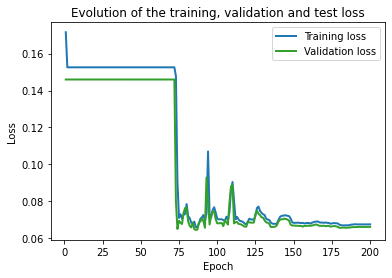

In [36]:
plot_loss(CES_oc_bm.train_loss_history, CES_oc_bm.val_loss_history)

In [41]:
import time

# Pick the best model for each test point
start = time.time()
best_loss_bm, best_model_bm, val_loss_history_bm = CES_oc_bm.select_model()
print('The best model for the benchmark is stored at:', best_model_bm)
print('selecting models takes:', time.time()-start)

The best model for the benchmark is stored at: ./models/oneClass/benchmarks\model174.pth
selecting models takes: 0.0


In [42]:
from inference import Conformal_PVals

model_list_bm = CES_oc_bm.model_list

# Compute conformity scores of calibration sets for each model
# this initialization will be a one-time effort.
cal_time = time.time()
C_PVals_bm = Conformal_PVals(net_bm, device, calib_loader_bm, model_list_bm, random_state = 0)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 18.24it/s]

Initialization done!
Calibration (one time effort) takes:10.97s.


In [44]:
pvals_bm = C_PVals_bm.compute_pvals(inputs, [best_model_bm]*len(inputs))

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 619.06it/s]

Finished computing p-values for 100 test points.


Average p-value for inliers is 0.580267, average p-value for outliers is 0.468679.


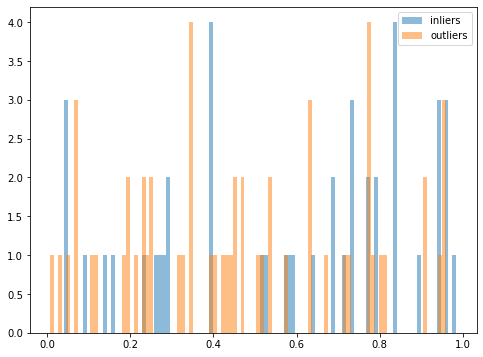

In [45]:
plot_pvals(pvals_bm, labels)

In [46]:
fdp, power = evaluate_bh(pvals_bm, labels, alpha=0.1)
print('Apply BH procedure yields FDP {:3f}, power {:3f}.'.format(fdp,power))

Apply BH procedure yields FDP 0.000000, power 0.000000.


### Train with CES data splitting and apply CES method

In [37]:
seed = 1
np.random.seed(seed)
th.manual_seed(seed)

net_ces = ConvAutoencoder()
Loss = th.nn.MSELoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, inputs)
optimizer_ces = optim.Adam(net_ces.parameters(), lr=lr)


# Initialize the CES class with model parameters
CES_oc_ces = CES_oneClass(net_ces, device, train_loader_ces, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=escal_loader_ces, criterion=criterion,optimizer=optimizer_ces)

===== HYPERPARAMETERS =====
batch_size= 10
n_epochs= 200
learning_rate= 0.1


In [38]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_oc_ces.full_train(save_dir = './models/oneClass/ces', save_every = save_every)

Epoch 1 of 200, 8% 	 train_loss: 0.17  took: 0.04s
Epoch 1 of 200, 17% 	 train_loss: 0.11  took: 0.02s
Epoch 1 of 200, 26% 	 train_loss: 0.10  took: 0.03s
Epoch 1 of 200, 34% 	 train_loss: 0.08  took: 0.03s
Epoch 1 of 200, 43% 	 train_loss: 0.09  took: 0.03s
Epoch 1 of 200, 52% 	 train_loss: 0.07  took: 0.02s
Epoch 1 of 200, 60% 	 train_loss: 0.07  took: 0.03s
Epoch 1 of 200, 69% 	 train_loss: 0.07  took: 0.02s
Epoch 1 of 200, 78% 	 train_loss: 0.06  took: 0.01s
Epoch 1 of 200, 86% 	 train_loss: 0.06  took: 0.03s
Epoch 1 of 200, 95% 	 train_loss: 0.06  took: 0.02s
val_loss = 0.05
Snapshot saved at epoch 1.
Epoch 2 of 200, 8% 	 train_loss: 0.05  took: 0.03s
Epoch 2 of 200, 17% 	 train_loss: 0.05  took: 0.03s
Epoch 2 of 200, 26% 	 train_loss: 0.06  took: 0.03s
Epoch 2 of 200, 34% 	 train_loss: 0.05  took: 0.03s
Epoch 2 of 200, 43% 	 train_loss: 0.05  took: 0.02s
Epoch 2 of 200, 52% 	 train_loss: 0.05  took: 0.02s
Epoch 2 of 200, 60% 	 train_loss: 0.05  took: 0.02s
Epoch 2 of 200, 69% 	 t

Epoch 14 of 200, 86% 	 train_loss: 0.02  took: 0.02s
Epoch 14 of 200, 95% 	 train_loss: 0.02  took: 0.03s
val_loss = 0.02
Snapshot saved at epoch 14.
Epoch 15 of 200, 8% 	 train_loss: 0.02  took: 0.05s
Epoch 15 of 200, 17% 	 train_loss: 0.02  took: 0.01s
Epoch 15 of 200, 26% 	 train_loss: 0.02  took: 0.02s
Epoch 15 of 200, 34% 	 train_loss: 0.02  took: 0.05s
Epoch 15 of 200, 43% 	 train_loss: 0.02  took: 0.02s
Epoch 15 of 200, 52% 	 train_loss: 0.02  took: 0.02s
Epoch 15 of 200, 60% 	 train_loss: 0.02  took: 0.01s
Epoch 15 of 200, 69% 	 train_loss: 0.02  took: 0.02s
Epoch 15 of 200, 78% 	 train_loss: 0.02  took: 0.03s
Epoch 15 of 200, 86% 	 train_loss: 0.02  took: 0.02s
Epoch 15 of 200, 95% 	 train_loss: 0.02  took: 0.03s
val_loss = 0.02
Snapshot saved at epoch 15.
Epoch 16 of 200, 8% 	 train_loss: 0.02  took: 0.03s
Epoch 16 of 200, 17% 	 train_loss: 0.02  took: 0.02s
Epoch 16 of 200, 26% 	 train_loss: 0.02  took: 0.01s
Epoch 16 of 200, 34% 	 train_loss: 0.02  took: 0.02s
Epoch 16 of 2

Epoch 28 of 200, 17% 	 train_loss: 0.02  took: 0.02s
Epoch 28 of 200, 26% 	 train_loss: 0.02  took: 0.02s
Epoch 28 of 200, 34% 	 train_loss: 0.02  took: 0.02s
Epoch 28 of 200, 43% 	 train_loss: 0.02  took: 0.02s
Epoch 28 of 200, 52% 	 train_loss: 0.02  took: 0.02s
Epoch 28 of 200, 60% 	 train_loss: 0.01  took: 0.02s
Epoch 28 of 200, 69% 	 train_loss: 0.01  took: 0.02s
Epoch 28 of 200, 78% 	 train_loss: 0.02  took: 0.02s
Epoch 28 of 200, 86% 	 train_loss: 0.02  took: 0.02s
Epoch 28 of 200, 95% 	 train_loss: 0.01  took: 0.02s
val_loss = 0.02
Snapshot saved at epoch 28.
Epoch 29 of 200, 8% 	 train_loss: 0.01  took: 0.02s
Epoch 29 of 200, 17% 	 train_loss: 0.02  took: 0.02s
Epoch 29 of 200, 26% 	 train_loss: 0.02  took: 0.01s
Epoch 29 of 200, 34% 	 train_loss: 0.02  took: 0.04s
Epoch 29 of 200, 43% 	 train_loss: 0.01  took: 0.02s
Epoch 29 of 200, 52% 	 train_loss: 0.02  took: 0.02s
Epoch 29 of 200, 60% 	 train_loss: 0.01  took: 0.02s
Epoch 29 of 200, 69% 	 train_loss: 0.02  took: 0.02s
Epo

Epoch 41 of 200, 69% 	 train_loss: 0.01  took: 0.03s
Epoch 41 of 200, 78% 	 train_loss: 0.02  took: 0.03s
Epoch 41 of 200, 86% 	 train_loss: 0.02  took: 0.02s
Epoch 41 of 200, 95% 	 train_loss: 0.01  took: 0.03s
val_loss = 0.02
Snapshot saved at epoch 41.
Epoch 42 of 200, 8% 	 train_loss: 0.02  took: 0.03s
Epoch 42 of 200, 17% 	 train_loss: 0.02  took: 0.03s
Epoch 42 of 200, 26% 	 train_loss: 0.02  took: 0.03s
Epoch 42 of 200, 34% 	 train_loss: 0.02  took: 0.02s
Epoch 42 of 200, 43% 	 train_loss: 0.01  took: 0.03s
Epoch 42 of 200, 52% 	 train_loss: 0.02  took: 0.02s
Epoch 42 of 200, 60% 	 train_loss: 0.01  took: 0.02s
Epoch 42 of 200, 69% 	 train_loss: 0.01  took: 0.02s
Epoch 42 of 200, 78% 	 train_loss: 0.02  took: 0.03s
Epoch 42 of 200, 86% 	 train_loss: 0.02  took: 0.03s
Epoch 42 of 200, 95% 	 train_loss: 0.01  took: 0.02s
val_loss = 0.02
Snapshot saved at epoch 42.
Epoch 43 of 200, 8% 	 train_loss: 0.01  took: 0.05s
Epoch 43 of 200, 17% 	 train_loss: 0.01  took: 0.02s
Epoch 43 of 2

Epoch 54 of 200, 86% 	 train_loss: 0.02  took: 0.03s
Epoch 54 of 200, 95% 	 train_loss: 0.01  took: 0.02s
val_loss = 0.02
Snapshot saved at epoch 54.
Epoch 55 of 200, 8% 	 train_loss: 0.01  took: 0.03s
Epoch 55 of 200, 17% 	 train_loss: 0.01  took: 0.03s
Epoch 55 of 200, 26% 	 train_loss: 0.01  took: 0.02s
Epoch 55 of 200, 34% 	 train_loss: 0.01  took: 0.02s
Epoch 55 of 200, 43% 	 train_loss: 0.01  took: 0.02s
Epoch 55 of 200, 52% 	 train_loss: 0.02  took: 0.03s
Epoch 55 of 200, 60% 	 train_loss: 0.01  took: 0.02s
Epoch 55 of 200, 69% 	 train_loss: 0.01  took: 0.03s
Epoch 55 of 200, 78% 	 train_loss: 0.02  took: 0.03s
Epoch 55 of 200, 86% 	 train_loss: 0.02  took: 0.03s
Epoch 55 of 200, 95% 	 train_loss: 0.01  took: 0.02s
val_loss = 0.02
Snapshot saved at epoch 55.
Epoch 56 of 200, 8% 	 train_loss: 0.02  took: 0.03s
Epoch 56 of 200, 17% 	 train_loss: 0.02  took: 0.03s
Epoch 56 of 200, 26% 	 train_loss: 0.02  took: 0.02s
Epoch 56 of 200, 34% 	 train_loss: 0.02  took: 0.02s
Epoch 56 of 2

Epoch 68 of 200, 43% 	 train_loss: 0.01  took: 0.02s
Epoch 68 of 200, 52% 	 train_loss: 0.02  took: 0.02s
Epoch 68 of 200, 60% 	 train_loss: 0.01  took: 0.02s
Epoch 68 of 200, 69% 	 train_loss: 0.01  took: 0.03s
Epoch 68 of 200, 78% 	 train_loss: 0.02  took: 0.02s
Epoch 68 of 200, 86% 	 train_loss: 0.02  took: 0.03s
Epoch 68 of 200, 95% 	 train_loss: 0.01  took: 0.02s
val_loss = 0.02
Snapshot saved at epoch 68.
Epoch 69 of 200, 8% 	 train_loss: 0.01  took: 0.03s
Epoch 69 of 200, 17% 	 train_loss: 0.01  took: 0.03s
Epoch 69 of 200, 26% 	 train_loss: 0.01  took: 0.02s
Epoch 69 of 200, 34% 	 train_loss: 0.01  took: 0.02s
Epoch 69 of 200, 43% 	 train_loss: 0.01  took: 0.03s
Epoch 69 of 200, 52% 	 train_loss: 0.02  took: 0.02s
Epoch 69 of 200, 60% 	 train_loss: 0.01  took: 0.02s
Epoch 69 of 200, 69% 	 train_loss: 0.01  took: 0.03s
Epoch 69 of 200, 78% 	 train_loss: 0.02  took: 0.02s
Epoch 69 of 200, 86% 	 train_loss: 0.02  took: 0.02s
Epoch 69 of 200, 95% 	 train_loss: 0.01  took: 0.03s
val

Epoch 81 of 200, 69% 	 train_loss: 0.01  took: 0.02s
Epoch 81 of 200, 78% 	 train_loss: 0.01  took: 0.04s
Epoch 81 of 200, 86% 	 train_loss: 0.01  took: 0.02s
Epoch 81 of 200, 95% 	 train_loss: 0.01  took: 0.02s
val_loss = 0.02
Snapshot saved at epoch 81.
Epoch 82 of 200, 8% 	 train_loss: 0.01  took: 0.03s
Epoch 82 of 200, 17% 	 train_loss: 0.01  took: 0.02s
Epoch 82 of 200, 26% 	 train_loss: 0.01  took: 0.02s
Epoch 82 of 200, 34% 	 train_loss: 0.01  took: 0.01s
Epoch 82 of 200, 43% 	 train_loss: 0.01  took: 0.03s
Epoch 82 of 200, 52% 	 train_loss: 0.02  took: 0.02s
Epoch 82 of 200, 60% 	 train_loss: 0.01  took: 0.04s
Epoch 82 of 200, 69% 	 train_loss: 0.01  took: 0.02s
Epoch 82 of 200, 78% 	 train_loss: 0.01  took: 0.03s
Epoch 82 of 200, 86% 	 train_loss: 0.01  took: 0.01s
Epoch 82 of 200, 95% 	 train_loss: 0.01  took: 0.02s
val_loss = 0.02
Snapshot saved at epoch 82.
Epoch 83 of 200, 8% 	 train_loss: 0.01  took: 0.06s
Epoch 83 of 200, 17% 	 train_loss: 0.01  took: 0.03s
Epoch 83 of 2

Epoch 95 of 200, 26% 	 train_loss: 0.01  took: 0.05s
Epoch 95 of 200, 34% 	 train_loss: 0.01  took: 0.04s
Epoch 95 of 200, 43% 	 train_loss: 0.01  took: 0.02s
Epoch 95 of 200, 52% 	 train_loss: 0.02  took: 0.02s
Epoch 95 of 200, 60% 	 train_loss: 0.01  took: 0.04s
Epoch 95 of 200, 69% 	 train_loss: 0.01  took: 0.02s
Epoch 95 of 200, 78% 	 train_loss: 0.02  took: 0.05s
Epoch 95 of 200, 86% 	 train_loss: 0.02  took: 0.03s
Epoch 95 of 200, 95% 	 train_loss: 0.01  took: 0.03s
val_loss = 0.02
Snapshot saved at epoch 95.
Epoch 96 of 200, 8% 	 train_loss: 0.01  took: 0.03s
Epoch 96 of 200, 17% 	 train_loss: 0.01  took: 0.03s
Epoch 96 of 200, 26% 	 train_loss: 0.01  took: 0.03s
Epoch 96 of 200, 34% 	 train_loss: 0.01  took: 0.03s
Epoch 96 of 200, 43% 	 train_loss: 0.01  took: 0.02s
Epoch 96 of 200, 52% 	 train_loss: 0.02  took: 0.03s
Epoch 96 of 200, 60% 	 train_loss: 0.01  took: 0.03s
Epoch 96 of 200, 69% 	 train_loss: 0.01  took: 0.03s
Epoch 96 of 200, 78% 	 train_loss: 0.02  took: 0.03s
Epo

Epoch 108 of 200, 95% 	 train_loss: 0.01  took: 0.02s
val_loss = 0.02
Snapshot saved at epoch 108.
Epoch 109 of 200, 8% 	 train_loss: 0.01  took: 0.02s
Epoch 109 of 200, 17% 	 train_loss: 0.01  took: 0.02s
Epoch 109 of 200, 26% 	 train_loss: 0.01  took: 0.02s
Epoch 109 of 200, 34% 	 train_loss: 0.01  took: 0.03s
Epoch 109 of 200, 43% 	 train_loss: 0.01  took: 0.02s
Epoch 109 of 200, 52% 	 train_loss: 0.02  took: 0.02s
Epoch 109 of 200, 60% 	 train_loss: 0.01  took: 0.02s
Epoch 109 of 200, 69% 	 train_loss: 0.01  took: 0.02s
Epoch 109 of 200, 78% 	 train_loss: 0.01  took: 0.02s
Epoch 109 of 200, 86% 	 train_loss: 0.01  took: 0.02s
Epoch 109 of 200, 95% 	 train_loss: 0.01  took: 0.04s
val_loss = 0.02
Snapshot saved at epoch 109.
Epoch 110 of 200, 8% 	 train_loss: 0.01  took: 0.03s
Epoch 110 of 200, 17% 	 train_loss: 0.01  took: 0.02s
Epoch 110 of 200, 26% 	 train_loss: 0.01  took: 0.02s
Epoch 110 of 200, 34% 	 train_loss: 0.01  took: 0.03s
Epoch 110 of 200, 43% 	 train_loss: 0.01  took: 

Epoch 122 of 200, 8% 	 train_loss: 0.01  took: 0.03s
Epoch 122 of 200, 17% 	 train_loss: 0.01  took: 0.03s
Epoch 122 of 200, 26% 	 train_loss: 0.02  took: 0.02s
Epoch 122 of 200, 34% 	 train_loss: 0.01  took: 0.02s
Epoch 122 of 200, 43% 	 train_loss: 0.01  took: 0.02s
Epoch 122 of 200, 52% 	 train_loss: 0.02  took: 0.03s
Epoch 122 of 200, 60% 	 train_loss: 0.01  took: 0.02s
Epoch 122 of 200, 69% 	 train_loss: 0.01  took: 0.02s
Epoch 122 of 200, 78% 	 train_loss: 0.01  took: 0.03s
Epoch 122 of 200, 86% 	 train_loss: 0.01  took: 0.03s
Epoch 122 of 200, 95% 	 train_loss: 0.01  took: 0.03s
val_loss = 0.02
Snapshot saved at epoch 122.
Epoch 123 of 200, 8% 	 train_loss: 0.01  took: 0.02s
Epoch 123 of 200, 17% 	 train_loss: 0.01  took: 0.02s
Epoch 123 of 200, 26% 	 train_loss: 0.02  took: 0.03s
Epoch 123 of 200, 34% 	 train_loss: 0.01  took: 0.02s
Epoch 123 of 200, 43% 	 train_loss: 0.01  took: 0.04s
Epoch 123 of 200, 52% 	 train_loss: 0.02  took: 0.03s
Epoch 123 of 200, 60% 	 train_loss: 0.0

Epoch 135 of 200, 34% 	 train_loss: 0.01  took: 0.03s
Epoch 135 of 200, 43% 	 train_loss: 0.01  took: 0.03s
Epoch 135 of 200, 52% 	 train_loss: 0.02  took: 0.03s
Epoch 135 of 200, 60% 	 train_loss: 0.01  took: 0.03s
Epoch 135 of 200, 69% 	 train_loss: 0.01  took: 0.03s
Epoch 135 of 200, 78% 	 train_loss: 0.01  took: 0.02s
Epoch 135 of 200, 86% 	 train_loss: 0.01  took: 0.03s
Epoch 135 of 200, 95% 	 train_loss: 0.01  took: 0.02s
val_loss = 0.02
Snapshot saved at epoch 135.
Epoch 136 of 200, 8% 	 train_loss: 0.01  took: 0.04s
Epoch 136 of 200, 17% 	 train_loss: 0.01  took: 0.03s
Epoch 136 of 200, 26% 	 train_loss: 0.01  took: 0.03s
Epoch 136 of 200, 34% 	 train_loss: 0.01  took: 0.03s
Epoch 136 of 200, 43% 	 train_loss: 0.01  took: 0.03s
Epoch 136 of 200, 52% 	 train_loss: 0.02  took: 0.03s
Epoch 136 of 200, 60% 	 train_loss: 0.01  took: 0.03s
Epoch 136 of 200, 69% 	 train_loss: 0.01  took: 0.03s
Epoch 136 of 200, 78% 	 train_loss: 0.02  took: 0.02s
Epoch 136 of 200, 86% 	 train_loss: 0.

Epoch 148 of 200, 26% 	 train_loss: 0.01  took: 0.03s
Epoch 148 of 200, 34% 	 train_loss: 0.01  took: 0.02s
Epoch 148 of 200, 43% 	 train_loss: 0.01  took: 0.02s
Epoch 148 of 200, 52% 	 train_loss: 0.02  took: 0.03s
Epoch 148 of 200, 60% 	 train_loss: 0.01  took: 0.02s
Epoch 148 of 200, 69% 	 train_loss: 0.01  took: 0.03s
Epoch 148 of 200, 78% 	 train_loss: 0.01  took: 0.02s
Epoch 148 of 200, 86% 	 train_loss: 0.01  took: 0.02s
Epoch 148 of 200, 95% 	 train_loss: 0.01  took: 0.03s
val_loss = 0.02
Snapshot saved at epoch 148.
Epoch 149 of 200, 8% 	 train_loss: 0.01  took: 0.03s
Epoch 149 of 200, 17% 	 train_loss: 0.01  took: 0.02s
Epoch 149 of 200, 26% 	 train_loss: 0.02  took: 0.02s
Epoch 149 of 200, 34% 	 train_loss: 0.01  took: 0.02s
Epoch 149 of 200, 43% 	 train_loss: 0.01  took: 0.02s
Epoch 149 of 200, 52% 	 train_loss: 0.02  took: 0.02s
Epoch 149 of 200, 60% 	 train_loss: 0.01  took: 0.03s
Epoch 149 of 200, 69% 	 train_loss: 0.01  took: 0.02s
Epoch 149 of 200, 78% 	 train_loss: 0.

Epoch 161 of 200, 17% 	 train_loss: 0.01  took: 0.03s
Epoch 161 of 200, 26% 	 train_loss: 0.02  took: 0.03s
Epoch 161 of 200, 34% 	 train_loss: 0.01  took: 0.03s
Epoch 161 of 200, 43% 	 train_loss: 0.01  took: 0.03s
Epoch 161 of 200, 52% 	 train_loss: 0.02  took: 0.03s
Epoch 161 of 200, 60% 	 train_loss: 0.01  took: 0.03s
Epoch 161 of 200, 69% 	 train_loss: 0.01  took: 0.03s
Epoch 161 of 200, 78% 	 train_loss: 0.02  took: 0.02s
Epoch 161 of 200, 86% 	 train_loss: 0.02  took: 0.03s
Epoch 161 of 200, 95% 	 train_loss: 0.01  took: 0.03s
val_loss = 0.02
Snapshot saved at epoch 161.
Epoch 162 of 200, 8% 	 train_loss: 0.01  took: 0.06s
Epoch 162 of 200, 17% 	 train_loss: 0.01  took: 0.02s
Epoch 162 of 200, 26% 	 train_loss: 0.01  took: 0.02s
Epoch 162 of 200, 34% 	 train_loss: 0.01  took: 0.03s
Epoch 162 of 200, 43% 	 train_loss: 0.01  took: 0.02s
Epoch 162 of 200, 52% 	 train_loss: 0.02  took: 0.03s
Epoch 162 of 200, 60% 	 train_loss: 0.01  took: 0.02s
Epoch 162 of 200, 69% 	 train_loss: 0.

val_loss = 0.02
Snapshot saved at epoch 173.
Epoch 174 of 200, 8% 	 train_loss: 0.01  took: 0.05s
Epoch 174 of 200, 17% 	 train_loss: 0.01  took: 0.05s
Epoch 174 of 200, 26% 	 train_loss: 0.01  took: 0.03s
Epoch 174 of 200, 34% 	 train_loss: 0.01  took: 0.03s
Epoch 174 of 200, 43% 	 train_loss: 0.01  took: 0.02s
Epoch 174 of 200, 52% 	 train_loss: 0.02  took: 0.03s
Epoch 174 of 200, 60% 	 train_loss: 0.01  took: 0.04s
Epoch 174 of 200, 69% 	 train_loss: 0.01  took: 0.02s
Epoch 174 of 200, 78% 	 train_loss: 0.01  took: 0.02s
Epoch 174 of 200, 86% 	 train_loss: 0.01  took: 0.04s
Epoch 174 of 200, 95% 	 train_loss: 0.01  took: 0.01s
val_loss = 0.01
Snapshot saved at epoch 174.
Epoch 175 of 200, 8% 	 train_loss: 0.01  took: 0.03s
Epoch 175 of 200, 17% 	 train_loss: 0.01  took: 0.03s
Epoch 175 of 200, 26% 	 train_loss: 0.01  took: 0.02s
Epoch 175 of 200, 34% 	 train_loss: 0.01  took: 0.02s
Epoch 175 of 200, 43% 	 train_loss: 0.01  took: 0.02s
Epoch 175 of 200, 52% 	 train_loss: 0.02  took: 

Epoch 187 of 200, 8% 	 train_loss: 0.01  took: 0.04s
Epoch 187 of 200, 17% 	 train_loss: 0.01  took: 0.03s
Epoch 187 of 200, 26% 	 train_loss: 0.01  took: 0.02s
Epoch 187 of 200, 34% 	 train_loss: 0.01  took: 0.03s
Epoch 187 of 200, 43% 	 train_loss: 0.01  took: 0.02s
Epoch 187 of 200, 52% 	 train_loss: 0.02  took: 0.02s
Epoch 187 of 200, 60% 	 train_loss: 0.01  took: 0.02s
Epoch 187 of 200, 69% 	 train_loss: 0.01  took: 0.02s
Epoch 187 of 200, 78% 	 train_loss: 0.01  took: 0.03s
Epoch 187 of 200, 86% 	 train_loss: 0.01  took: 0.02s
Epoch 187 of 200, 95% 	 train_loss: 0.01  took: 0.02s
val_loss = 0.02
Snapshot saved at epoch 187.
Epoch 188 of 200, 8% 	 train_loss: 0.01  took: 0.03s
Epoch 188 of 200, 17% 	 train_loss: 0.02  took: 0.03s
Epoch 188 of 200, 26% 	 train_loss: 0.02  took: 0.02s
Epoch 188 of 200, 34% 	 train_loss: 0.01  took: 0.02s
Epoch 188 of 200, 43% 	 train_loss: 0.01  took: 0.02s
Epoch 188 of 200, 52% 	 train_loss: 0.02  took: 0.03s
Epoch 188 of 200, 60% 	 train_loss: 0.0

Epoch 200 of 200, 17% 	 train_loss: 0.01  took: 0.03s
Epoch 200 of 200, 26% 	 train_loss: 0.01  took: 0.03s
Epoch 200 of 200, 34% 	 train_loss: 0.01  took: 0.02s
Epoch 200 of 200, 43% 	 train_loss: 0.01  took: 0.02s
Epoch 200 of 200, 52% 	 train_loss: 0.02  took: 0.02s
Epoch 200 of 200, 60% 	 train_loss: 0.01  took: 0.02s
Epoch 200 of 200, 69% 	 train_loss: 0.01  took: 0.02s
Epoch 200 of 200, 78% 	 train_loss: 0.01  took: 0.03s
Epoch 200 of 200, 86% 	 train_loss: 0.01  took: 0.02s
Epoch 200 of 200, 95% 	 train_loss: 0.01  took: 0.02s
val_loss = 0.02
Snapshot saved at epoch 200.
Training done! A list of 200 models saved.


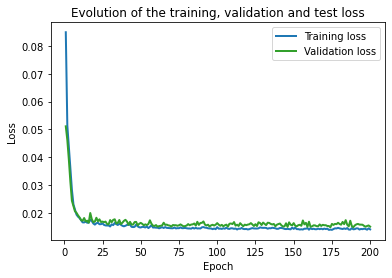

In [39]:
plot_loss(CES_oc_ces.train_loss_history, CES_oc_ces.val_loss_history)

In [27]:
# Pick the best model for each test point
start = time.time()
best_loss_ces, best_model_ces, test_val_loss_history_ces = CES_oc_ces.select_model(inputs)
print('selecting models takes:', time.time()-start)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1348.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1354.33it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1505.41it/s]

selecting models takes: 17.085031270980835


In [29]:
model_list_ces = CES_oc_ces.model_list

# Compute conformity scores of calibration sets for each model
# this initialization will be a one-time effort.
cal_time = time.time()
C_PVals_ces = Conformal_PVals(net_ces, device, escal_loader_ces, model_list_ces, random_state = 0)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 34.32it/s]

Initialization done!
Calibration (one time effort) takes:5.86s.


In [30]:
pvals_ces = C_PVals_ces.compute_pvals(inputs, best_model_ces)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 717.30it/s]

Finished computing p-values for 100 test points.


Average p-value for inliers is 0.495514, average p-value for outliers is 0.101269.


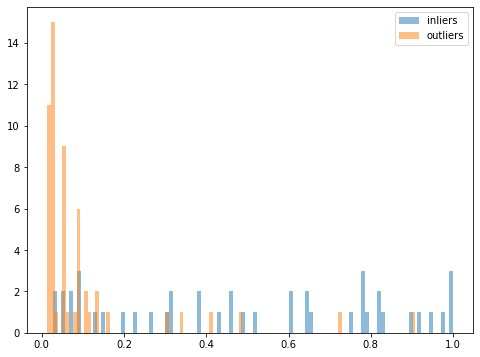

In [31]:
plot_pvals(pvals_ces, labels)

In [32]:
fdp, power = evaluate_bh(pvals_ces, labels, alpha=0.1)
print('Apply BH procedure yields FDP {:3f}, power {:3f}.'.format(fdp,power))

Apply BH procedure yields FDP 0.090000, power 0.785714.


## Apply the naive benchmark
The naive benchmark method uses the same data splitting scheme as CES but it naively use the validation set for both model selection and calibration, hence losing the exchangeability between test points and validation points, potentially causes FDR inflation. The following section explores this naive benchmark and its performance.


In [59]:
# Pick the best model for each test point
start = time.time()
best_loss_naive, best_model_naive, val_loss_history_naive = CES_oc_ces.select_model()
print('best model selected by naive method is stored at:', best_model_naive)
print('selecting models takes:', time.time()-start)

best model selected by naive method is stored at: ./models/oneClass/ces\model182.pth
selecting models takes: 0.0


In [60]:
pvals_naive = C_PVals_ces.compute_pvals(inputs, [best_model_naive]*len(inputs))

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 756.25it/s]

Finished computing p-values for 100 test points.


Average p-value for inliers is 0.480423, average p-value for outliers is 0.103430.


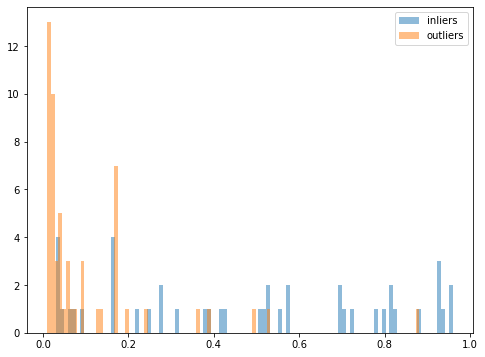

In [61]:
plot_pvals(pvals_naive, labels)

In [62]:
fdp, power = evaluate_bh(pvals_naive, labels, alpha=0.1)
print('Apply BH procedure yields FDP {:3f}, power {:3f}.'.format(fdp,power))

Apply BH procedure yields FDP 0.070000, power 0.642857.


# Experiment 2: CES for multi-class classification

### Load CIFAR10 dataset

In [41]:
num_workers = 2

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Benchmark data-splitting vs CES data-splitting

In [47]:
from torch.utils.data.sampler import SubsetRandomSampler
num_workers = 0

seed = 0
np.random.seed(seed)
th.manual_seed(seed)

n_full = len(train_set)
n_data = 4000
n_es_bm = int(n_data*0.25)
n_calib_bm = n_es_bm
n_train_bm = n_data-n_es_bm-n_calib_bm

train_set_bm, es_set_bm, calib_set_bm, _ = th.utils.data.random_split(train_set,\
                                 [n_train_bm, n_es_bm, n_calib_bm, n_full-n_data])
print("Use {:d} training samples, {:d} early stopping samples, {:d} calibration samples for the Data splitting method."\
           .format(n_train_bm, n_es_bm, n_calib_bm))


# CES data splitting: calibration set is not needed, merge back to the training set
n_escal_ces = n_es_bm
n_train_ces = n_data-n_escal_ces

train_set_ces, escal_set_ces, _ = th.utils.data.random_split(train_set,\
                                 [n_train_ces, n_escal_ces, n_full-n_data])
print("Use {:d} training samples, {:d} early stopping samples, {:d} calibration samples for the CES method."\
     .format(n_train_ces, n_escal_ces, n_escal_ces))


Use 2000 training samples, 1000 early stopping samples, 1000 calibration samples for the Data splitting method.
Use 3000 training samples, 1000 early stopping samples, 1000 calibration samples for the CES method.


In [48]:
# Create data loader objects
# For benchmarks
batch_size = 64
num_workers = 4

train_loader_bm = th.utils.data.DataLoader(train_set_bm, batch_size=batch_size,
                                          num_workers=num_workers)

es_loader_bm = th.utils.data.DataLoader(es_set_bm, batch_size=100,
                                          num_workers=num_workers)

calib_loader_bm = th.utils.data.DataLoader(calib_set_bm, batch_size=100,
                                          num_workers=num_workers)

# For CES
train_loader_ces = th.utils.data.DataLoader(train_set_ces, batch_size=batch_size,
                                          num_workers=num_workers)

escal_loader_ces = th.utils.data.DataLoader(escal_set_ces, batch_size=100,
                                          num_workers=num_workers)

In [49]:
# Test loader

seed = 0
np.random.seed(seed)
th.manual_seed(seed)

n_test_samples = 100
n_test = len(test_set)

test_sample, _ = th.utils.data.random_split(test_set,[n_test_samples, n_test-n_test_samples])
test_loader = th.utils.data.DataLoader(test_sample, batch_size=n_test_samples, num_workers=num_workers)

# get all test images
dataiter = iter(test_loader)
inputs, labels = dataiter.next()

     horse        dog      horse       ship


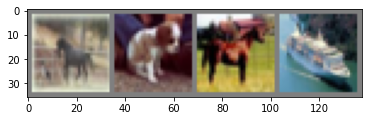

In [50]:
# Plot some sample test data

imshow(torchvision.utils.make_grid(inputs[:4]), norm=True)
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(4)))

### Define CNN

In [51]:
from method import CES_multiClass
from networks import SimpleConvolutionalNetwork
from inference import Conformal_PSet

In [58]:
import torch.optim as optim

# Define the model parameters
lr = 0.01
n_epoch = 10
n_classes = len(classes)

# Create loss and optimizer
# CES_oneClass object will assume criterion takes three parameters: output, input and target, 
# create wrapper function to modify the criterion.
net_bm = SimpleConvolutionalNetwork()
Loss = th.nn.CrossEntropyLoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, targets)
optimizer_bm = optim.Adam(net_bm.parameters(), lr=lr)

In [59]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

### Train the benchmark model

In [60]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# Initialize the CES class with model parameters
CES_mc_bm = CES_multiClass(net_bm, device, train_loader_bm, n_classes=n_classes, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=es_loader_bm, criterion=criterion,optimizer=optimizer_bm)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 10
learning_rate= 0.01


In [61]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_mc_bm.full_train(save_dir = './models/multiClass/benchmarks', save_every = save_every)

Epoch 1 of 10, 9% 	 train_loss: 3.12 train_acc: 14.06% took: 6.04s
Epoch 1 of 10, 18% 	 train_loss: 2.50 train_acc: 13.02% took: 0.06s
Epoch 1 of 10, 28% 	 train_loss: 2.29 train_acc: 15.62% took: 0.07s
Epoch 1 of 10, 37% 	 train_loss: 2.22 train_acc: 17.71% took: 0.07s
Epoch 1 of 10, 46% 	 train_loss: 2.17 train_acc: 17.19% took: 0.07s
Epoch 1 of 10, 56% 	 train_loss: 2.16 train_acc: 18.23% took: 0.07s
Epoch 1 of 10, 65% 	 train_loss: 2.11 train_acc: 22.40% took: 0.07s
Epoch 1 of 10, 75% 	 train_loss: 2.13 train_acc: 19.79% took: 0.07s
Epoch 1 of 10, 84% 	 train_loss: 2.13 train_acc: 20.83% took: 0.07s
Epoch 1 of 10, 93% 	 train_loss: 2.09 train_acc: 27.08% took: 0.07s
val_loss = 2.09 val_acc = 20.20%
Snapshot saved at epoch 1.
Epoch 2 of 10, 9% 	 train_loss: 2.06 train_acc: 24.48% took: 6.13s
Epoch 2 of 10, 18% 	 train_loss: 2.03 train_acc: 28.65% took: 0.07s
Epoch 2 of 10, 28% 	 train_loss: 2.00 train_acc: 25.52% took: 0.07s
Epoch 2 of 10, 37% 	 train_loss: 1.92 train_acc: 28.65% to

In [63]:
%load_ext autoreload
%autoreload 2
import time
from inference import Conformal_PSet

alpha = 0.1
n_classes = len(classes)
model_list_bm = CES_mc_bm.model_list     # Get the saved model list from the CES class

# Compute conformity scores of calibration sets for each model and corresponding calibrated
# confidence level, this might take some time if we have too many saved models but fortunately
# this initialization will be a one-time effort.
cal_time = time.time()
C_PSet_bm = Conformal_PSet(net_bm, device, calib_loader_bm, n_classes, model_list_bm, \
                           alpha, lc=True, random_state=0)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:06<00:00,  6.65s/it]

Initialization done!
Calibration (one time effort) takes:66.52s.


In [64]:
# Pick the best model for each test point
start = time.time()
best_loss_bm, best_model_bm, test_val_loss_history_bm = CES_mc_bm.select_model()
print('selecting models takes:', time.time()-start)

selecting models takes: 0.0


In [65]:
# Get the marginal conformal pvalues 
pset_m_bm= C_PSet_bm.pred_set(inputs, [[best_model_bm]*n_classes]*len(inputs), marginal=True)
# Get the label conditional conformal pvalues 
pset_lc_bm = C_PSet_bm.pred_set(inputs, [[best_model_bm]*n_classes]*len(inputs), marginal=False)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.25it/s]


Finished computing marginal prediction sets for 100 test points.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.16it/s]

Finished computing label conditional prediction sets for 100 test points.


In [66]:
print('Evaluate marginal prediction sets.')
print('='*50)
evaluate_marginal(pset_m_bm, labels.numpy())
print('='*50)
evaluate_conditional(pset_m_bm, labels.numpy())

Evaluate marginal prediction sets.
Marginal coverage:       94.000%
Average size:            5.360
Average size | coverage: 5.372
Conditional coverage for label plane:       75.000%
Average size:            5.375
Average size | coverage: 4.833
Conditional coverage for label car:       90.000%
Average size:            3.900
Average size | coverage: 4.222
Conditional coverage for label bird:       100.000%
Average size:            5.500
Average size | coverage: 5.500
Conditional coverage for label cat:       100.000%
Average size:            6.000
Average size | coverage: 6.000
Conditional coverage for label deer:       100.000%
Average size:            6.556
Average size | coverage: 6.556
Conditional coverage for label dog:       100.000%
Average size:            5.231
Average size | coverage: 5.231
Conditional coverage for label frog:       91.667%
Average size:            6.083
Average size | coverage: 6.182
Conditional coverage for label horse:       75.000%
Average size:            

In [67]:
print('Evaluate label conditional prediction sets.')
print('='*50)
evaluate_marginal(pset_lc_bm, labels.numpy())
print('='*50)
evaluate_conditional(pset_lc_bm, labels.numpy())

Evaluate label conditional prediction sets.
Marginal coverage:       95.000%
Average size:            5.170
Average size | coverage: 5.232
Conditional coverage for label plane:       87.500%
Average size:            5.125
Average size | coverage: 5.000
Conditional coverage for label car:       90.000%
Average size:            3.900
Average size | coverage: 4.222
Conditional coverage for label bird:       100.000%
Average size:            5.833
Average size | coverage: 5.833
Conditional coverage for label cat:       100.000%
Average size:            6.500
Average size | coverage: 6.500
Conditional coverage for label deer:       100.000%
Average size:            6.000
Average size | coverage: 6.000
Conditional coverage for label dog:       100.000%
Average size:            5.615
Average size | coverage: 5.615
Conditional coverage for label frog:       91.667%
Average size:            5.500
Average size | coverage: 5.545
Conditional coverage for label horse:       100.000%
Average size:  

### Train the CES model

In [70]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

net_ces = SimpleConvolutionalNetwork()
Loss = th.nn.CrossEntropyLoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, targets)
optimizer_ces = optim.Adam(net_ces.parameters(), lr=lr)

# Initialize the CES class with model parameters
CES_mc_ces = CES_multiClass(net_ces, device, train_loader_ces, n_classes=n_classes, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=escal_loader_ces, criterion=criterion,optimizer=optimizer_ces)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 10
learning_rate= 0.01


In [71]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

In [72]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_mc_ces.full_train(save_dir = './models/multiClass/ces', save_every = save_every)

Epoch 1 of 10, 8% 	 train_loss: 3.74 train_acc: 11.33% took: 6.09s
Epoch 1 of 10, 17% 	 train_loss: 2.48 train_acc: 13.28% took: 0.09s
Epoch 1 of 10, 25% 	 train_loss: 2.36 train_acc: 13.67% took: 0.10s
Epoch 1 of 10, 34% 	 train_loss: 2.30 train_acc: 10.94% took: 0.09s
Epoch 1 of 10, 42% 	 train_loss: 2.21 train_acc: 15.23% took: 0.10s
Epoch 1 of 10, 51% 	 train_loss: 2.23 train_acc: 13.67% took: 0.09s
Epoch 1 of 10, 59% 	 train_loss: 2.16 train_acc: 18.36% took: 0.10s
Epoch 1 of 10, 68% 	 train_loss: 2.09 train_acc: 23.44% took: 0.08s
Epoch 1 of 10, 76% 	 train_loss: 2.10 train_acc: 25.39% took: 0.09s
Epoch 1 of 10, 85% 	 train_loss: 2.00 train_acc: 25.00% took: 0.10s
Epoch 1 of 10, 93% 	 train_loss: 2.04 train_acc: 23.83% took: 0.10s
val_loss = 2.00 val_acc = 26.30%
Snapshot saved at epoch 1.
Epoch 2 of 10, 8% 	 train_loss: 2.01 train_acc: 23.83% took: 6.19s
Epoch 2 of 10, 17% 	 train_loss: 2.01 train_acc: 24.61% took: 0.08s
Epoch 2 of 10, 25% 	 train_loss: 1.97 train_acc: 29.30% to

In [73]:
alpha = 0.1
model_list_ces = CES_mc_ces.model_list     # Get the saved model list from the CES class

# Compute conformity scores of calibration sets for each model and corresponding calibrated
# confidence level, this might take some time if we have too many saved models but fortunately
# this initialization will be a one-time effort.
cal_time = time.time()
C_PSet_ces = Conformal_PSet(net_ces, device, escal_loader_ces, n_classes, model_list_ces, \
                           alpha,random_state = 0)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.90s/it]

Initialization done!
Calibration (one time effort) takes:78.97s.


In [74]:
# Pick the best model for each test point
start = time.time()
best_loss_ces, best_model_ces, test_val_loss_history_ces = CES_mc_ces.select_model(inputs)
print('selecting models takes:', time.time()-start)

Loading model 0 of 10...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 198.84it/s]

Loading model 1 of 10...



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 198.81it/s]

Loading model 2 of 10...



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 195.84it/s]

Loading model 3 of 10...



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 200.61it/s]

Loading model 4 of 10...



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 199.05it/s]

Loading model 5 of 10...



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 198.89it/s]

Loading model 6 of 10...



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 200.99it/s]

Loading model 7 of 10...



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 199.41it/s]

Loading model 8 of 10...



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 199.27it/s]

Loading model 9 of 10...



100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 203.65it/s]

selecting models takes: 5.1065919399261475


In [75]:
# Get the marginal conformal pvalues 
pset_m_ces= C_PSet_ces.pred_set(inputs, best_model_ces, marginal=True)
# Get the label conditional conformal pvalues 
pset_lc_ces = C_PSet_ces.pred_set(inputs, best_model_ces, marginal=False)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.19it/s]


Finished computing marginal prediction sets for 100 test points.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.27it/s]

Finished computing label conditional prediction sets for 100 test points.


In [78]:
print('Evaluate marginal prediction sets.')
print('='*50)
evaluate_marginal(pset_m_ces, labels.numpy())
print('='*50)
evaluate_conditional(pset_m_ces, labels.numpy())

Evaluate marginal prediction sets.
Marginal coverage:       93.000%
Average size:            4.690
Average size | coverage: 4.763
Conditional coverage for label plane:       87.500%
Average size:            4.000
Average size | coverage: 4.000
Conditional coverage for label car:       90.000%
Average size:            4.400
Average size | coverage: 4.333
Conditional coverage for label bird:       83.333%
Average size:            3.833
Average size | coverage: 4.200
Conditional coverage for label cat:       100.000%
Average size:            5.000
Average size | coverage: 5.000
Conditional coverage for label deer:       100.000%
Average size:            5.556
Average size | coverage: 5.556
Conditional coverage for label dog:       92.308%
Average size:            4.385
Average size | coverage: 4.667
Conditional coverage for label frog:       91.667%
Average size:            5.833
Average size | coverage: 6.000
Conditional coverage for label horse:       87.500%
Average size:            5.

In [79]:
print('Evaluate label conditional prediction sets.')
print('='*50)
evaluate_marginal(pset_lc_ces, labels.numpy())
print('='*50)
evaluate_conditional(pset_lc_ces, labels.numpy())

Evaluate label conditional prediction sets.
Marginal coverage:       93.000%
Average size:            4.820
Average size | coverage: 4.914
Conditional coverage for label plane:       87.500%
Average size:            4.375
Average size | coverage: 4.429
Conditional coverage for label car:       90.000%
Average size:            4.100
Average size | coverage: 4.111
Conditional coverage for label bird:       83.333%
Average size:            4.167
Average size | coverage: 4.600
Conditional coverage for label cat:       100.000%
Average size:            5.333
Average size | coverage: 5.333
Conditional coverage for label deer:       100.000%
Average size:            5.333
Average size | coverage: 5.333
Conditional coverage for label dog:       84.615%
Average size:            4.692
Average size | coverage: 5.091
Conditional coverage for label frog:       91.667%
Average size:            6.000
Average size | coverage: 6.182
Conditional coverage for label horse:       100.000%
Average size:    